# This notebook is meant to create functions for plotting 

Goal is then to add them to the classes or to use to check that everything is well

In [149]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import os
import glob
import sys
import yaml

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tempest import casestudy
from tempest import grid
from tempest import joint_distrib
from tempest import handler

settings_path = 'settings/tropics.yaml'

In [151]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, verbose = False)
gr = grid.Grid(cs, verbose = False, overwrite = False)
# jd = joint_distrib.JointDistribution(gr)


Data loaded from /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/DYAMOND_SAM_Tropics/grid_attributes.pkl instead of computing


In [152]:
jd = joint_distrib.JointDistribution(gr, nd=5, storm_tracking=True)

Distribs loaded
Overwrite set to false so loading basics attributes from .npy
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz


In [139]:
label = 353
storm = jd.storms[label]
lifecycle = storm.clusters

In [140]:
utc_0, utc_f = storm.Utime_Init, storm.Utime_End
i_0, i_f = hdlr.i_t_from_utc(utc_0)-1, hdlr.i_t_from_utc(utc_f)+1

print(utc_0, i_0)

17045.03 1490


In [141]:
import numpy as np

length = max(storm.latmax - storm.latmin, storm.lonmax - storm.lonmin)
bordersize = 5
i_t = i_0 + 5

# Use np.isclose to handle potential floating-point differences
if np.isclose(storm.latmax - storm.latmin, length):
    latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
    lonmid = (storm.lonmin + storm.lonmax) / 2
    lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
else : 
    latmid = (storm.lonmin + storm.lonmax) / 2
    latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
    lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
    
print("longitude min and max", lonmin, lonmax)
print("latitude min and max", latmin, latmax)

seg = hdlr.load_seg(i_t).sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))[0, :, :]
n_lat, n_lon = seg.shape
n = min(seg.shape)
seg = seg[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2]

longitude min and max 171.05 181.99
latitude min and max -13.94 -2.2600000000000016


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [142]:
i = i_t - i_0 - 1 # weird because this exists only at i_0 + 1 since, at i_0 mcs ain't created
cm_lat, cm_lon = lifecycle.lat[i], lifecycle.lon[i]
var_id = "Prec"
unit = "mm/h"
cmap = "ocean_r"
var = hdlr.load_var(gr, var_id, i_t)
var = var.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :] # approximate square
var = var[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2] # exact square

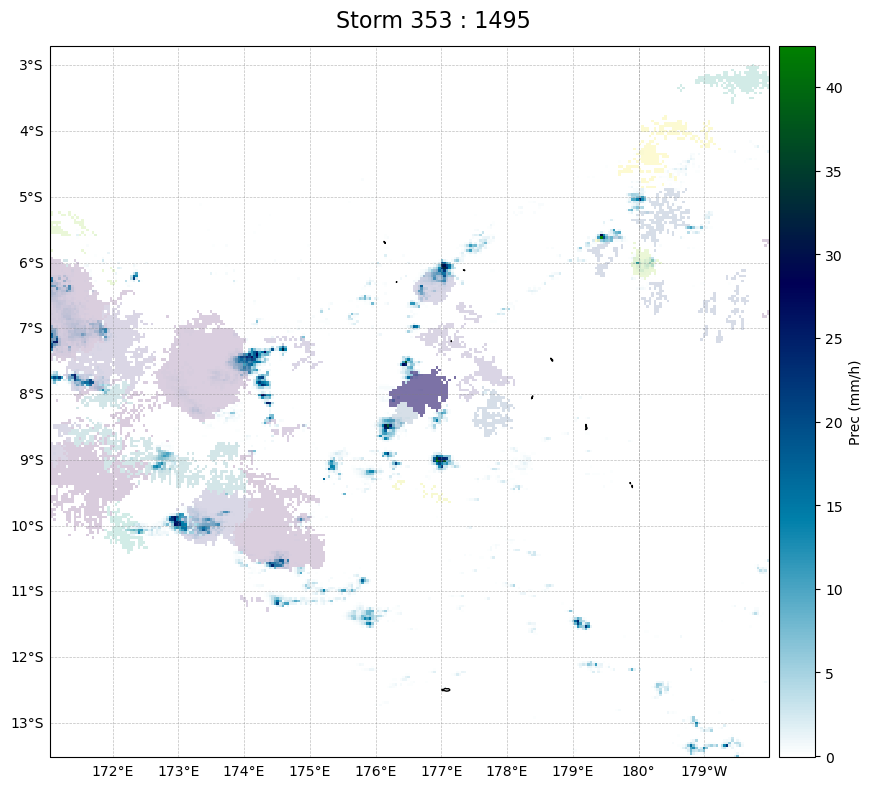

In [153]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

cloud_mask = (seg == storm.label)
# Set alpha values for clouds based on the mask
alpha_values = np.where(cloud_mask, 0.7, 0.2)

fig, ax = plt.subplots(subplot_kw=dict(projection = ccrs.PlateCarree(central_longitude = lonmax + lonmin / 2)), figsize=(10, 8))
lon, lat = seg.longitude.values, seg.latitude.values

v = ax.pcolormesh(lon, lat, var, cmap=cmap, transform=ccrs.PlateCarree())

c = ax.pcolormesh(lon, lat, seg,  transform=ccrs.PlateCarree(), cmap="viridis", alpha=alpha_values) 

ax.coastlines()

# Adding gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
loc_interval = 1
gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
gl.top_labels = False  # Turn off labels on the top x-axis
gl.right_labels = False  # Turn off labels on the right y-axis
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Create colorbar in a separate axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
label_name = f'{var_id} ({unit})'  # Use actual variable name
cbar = plt.colorbar(v, cax=cax, orientation='vertical', label=label_name)


# Adjust layout for the colorbars
fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

plt.tight_layout()
# Save the figure if needed
# plt.savefig(path_stamp)

plt.show()

In [154]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

verbose = False

label = 353
storm = jd.storms[label]
lifecycle = storm.clusters

utc_0, utc_f = storm.Utime_Init, storm.Utime_End
#carefull here, we remove and add 1 as to see better the conditions of genesis and dissipation
i_0, i_f = hdlr.i_t_from_utc(utc_0)-1, hdlr.i_t_from_utc(utc_f)+1

var_id = "Prec"
var_unit = "mm/h"
var_cmap = jd.settings["cmap_specs"]["prec"]

length = max(storm.latmax - storm.latmin, storm.lonmax - storm.lonmin)
bordersize = 5

# Build the square
if np.isclose(storm.latmax - storm.latmin, length):
    latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
    lonmid = (storm.lonmin + storm.lonmax) / 2
    lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
else : 
    latmid = (storm.lonmin + storm.lonmax) / 2
    latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
    lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
    
if verbose : print(lonmin, lonmax, latmin, latmax)
    
for i_t in range(i_0, i_f):
    
    seg = hdlr.load_seg(i_t).sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))[0, :, :]
    n_lat, n_lon = seg.shape
    n = min(seg.shape)
    seg = seg[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2]
    
    #relative index to i_0, used to catch data from the lifecycle lists of the storm
    i = i_t - i_0 - 1 #weird because this exists only at i_0 + 1 since, at i_0 mcs ain't created
    cm_lat, cm_lon = lifecycle.lat[i], lifecycle.lon[i]
    
    var = hdlr.load_var(gr, var_id, i_t)
    var = var.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :] # approximate square
    var = var[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2] # exact square
    
    cloud_mask = (seg == storm.label)
    # Set alpha values for clouds based on the mask
    alpha_values = np.where(cloud_mask, 0.7, 0.2)

    fig, ax = plt.subplots(subplot_kw=dict(projection = ccrs.PlateCarree(central_longitude = lonmax + lonmin / 2)), figsize=(10, 8))
    lon, lat = seg.longitude.values, seg.latitude.values

    v = ax.pcolormesh(lon, lat, var, cmap=cmap, transform=ccrs.PlateCarree())

    c = ax.pcolormesh(lon, lat, seg,  transform=ccrs.PlateCarree(), cmap="viridis", alpha=alpha_values) 

    ax.coastlines()

    # Adding gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    loc_interval = 1
    gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
    gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
    gl.top_labels = False  # Turn off labels on the top x-axis
    gl.right_labels = False  # Turn off labels on the right y-axis
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Create colorbar in a separate axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    label_name = f'{var_id} ({unit})'  # Use actual variable name
    cbar = plt.colorbar(v, cax=cax, orientation='vertical', label=label_name)


    # Adjust layout for the colorbars
    fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

    plt.tight_layout() 
    # saving frames and making dirs in cache
    cache = os.path.join(cs.settings["DIR_TEMPDATA"], cs.name)

    if not os.path.exists(cache):
        os.makedirs(cache)
        print("Could be made at class level")

    figname = f"storm_{label}_{var_id}" #maybe show a better date than it here but will do
    dir_path = os.path.join(cache, figname)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"made {dir_path}, don't forget to delete")

    stamp = f"{i_t}"
    path_stamp = os.path.join(dir_path, stamp)
    plt.savefig(path_stamp)
    print(f"Timestamp {i_t} saved")
    plt.close(fig)
    

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


made /scratchx/mcarenso/tempest/DYAMOND_SAM_Tropics/storm_353_Prec, don't forget to delete
Timestamp 1490 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1491 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1492 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1493 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1494 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1495 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1496 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1497 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1498 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1499 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1500 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1501 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1502 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1503 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1504 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1505 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1506 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1507 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1508 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1509 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1510 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1511 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1512 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1513 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1514 saved


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Timestamp 1515 saved


In [155]:
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Output video file name
output_file = f"/home/mcarenso/code/tempest/figures/{label}.mp4"

# List all PNG files in the input directory
image_files = [file for file in os.listdir(dir_path) if file.endswith('.png')]
image_files.sort()  # Ensure sorted order

# Create a list to store image paths
image_paths = [os.path.join(dir_path, file) for file in image_files]

# Function to update the figure for each frame
def update_figure(i):
    img = plt.imread(image_paths[i])
    im.set_array(img)
    return [im]

# Create the video using Matplotlib's animation module
fig, ax = plt.subplots()
im = ax.imshow(plt.imread(image_paths[0]))

# You can customize other animation parameters such as interval, repeat, etc.
animation = animation.FuncAnimation(fig, update_figure, frames=len(image_paths), interval=500, blit=True)

animation.save(output_file, writer='ffmpeg', fps=1, dpi=300)

# Display the animation in the notebook
HTML(animation.to_jshtml())
plt.close(fig)

Multiple data


In [ ]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

verbose = False

label = 353
storm = jd.storms[label]
lifecycle = storm.clusters

utc_0, utc_f = storm.Utime_Init, storm.Utime_End
#carefull here, we remove and add 1 as to see better the conditions of genesis and dissipation
i_0, i_f = hdlr.i_t_from_utc(utc_0)-1, hdlr.i_t_from_utc(utc_f)+1

var_id = "Prec"
var_unit = "mm/h"
var_cmap = jd.settings["cmap_specs"]["prec"]

for i_t in range(i_0, i_f):
    
    length = max(storm.latmax - storm.latmin, storm.lonmax - storm.lonmin)
    bordersize = 5

    # Build the square
    if np.isclose(storm.latmax - storm.latmin, length):
        latmax, latmin = storm.latmax + bordersize, storm.latmin - bordersize
        lonmid = (storm.lonmin + storm.lonmax) / 2
        lonmax, lonmin = lonmid + bordersize + length / 2, lonmid - bordersize - length / 2
    else : 
        latmid = (storm.lonmin + storm.lonmax) / 2
        latmax, latmin = storm.latmax + bordersize + length / 2, storm.latmin - bordersize - length / 2
        lonmax, lonmin = storm.lonmax + bordersize, storm.lonmin - bordersize 
        
    if verbose : print(lonmin, lonmax, latmin, latmax)

    seg = hdlr.load_seg(i_t).sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))[0, :, :]
    n_lat, n_lon = seg.shape
    n = min(seg.shape)
    seg = seg[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2]
    
    #relative index to i_0, used to catch data from the lifecycle lists of the storm
    i = i_t - i_0 - 1 #weird because this exists only at i_0 + 1 since, at i_0 mcs ain't created
    cm_lat, cm_lon = lifecycle.lat[i], lifecycle.lon[i]

    var_ids = ["Prec", "PW", "T2mm", "Q2m"]
    var_units = ["mm/h", "mm", "K", "?"]
    var_cmaps = ["ocean_r", "Blues", "RdBu_r", "RdBu"]
    vars = []
    for var_id in var_ids:
        var = hdlr.load_var(gr, var_id, i_t)
        var = var.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))[:, :] # approximate square
        var = var[n_lat//2 - n//2 : n_lat//2 + n//2 , n_lon//2 - n//2 : n_lon//2 + n//2] # exact square
        vars.append(var)
        print(f"{var_id} loaded ;", end ='\t')
    
    
        # Assuming 'seg' is your array with cloud labels
    # Create a mask to identify the clouds with a specific label
    cloud_mask = (seg == storm.label)

    # Set alpha values for clouds based on the mask
    alpha_values = np.where(cloud_mask, 0.7, 0.2)

    fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection = ccrs.PlateCarree()), figsize=(20, 16))

    # Assuming var1, var2, var3, and var4 are your different variables
    var_list = vars

    for ax, var, var_id, unit, cmap in zip(axes.flatten(), var_list, var_ids, var_units, var_cmaps):
        # Set latitude and longitude ticks
        v = ax.pcolormesh(seg.longitude, seg.latitude, var, cmap=cmap, shading='auto', transform=ccrs.PlateCarree())

        c = ax.pcolormesh(seg.longitude, seg.latitude, seg, transform=ccrs.PlateCarree(), cmap='viridis', alpha=alpha_values)

        ax.coastlines()

        # Adding gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        loc_interval = 1
        gl.xlocator = mticker.FixedLocator(range(-180, 181, loc_interval))
        gl.ylocator = mticker.FixedLocator(range(-90, 91, loc_interval))
        gl.top_labels = False  # Turn off labels on the top x-axis
        gl.right_labels = False  # Turn off labels on the right y-axis
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        # Create colorbar in a separate axis
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
        label_name = f'{var_id} ({unit})'  # Use actual variable name
        cbar = plt.colorbar(v, cax=cax, orientation='vertical', label=label_name)

        # Set the projection for the colorbar axis
        # cax.set_projection(ccrs.PlateCarree())

    # Adjust layout for the colorbars
    fig.suptitle(f"Storm {label} : {i_t}", fontsize=16)

    plt.tight_layout()

    # saving frames and making dirs in cache
    cache = os.path.join(cs.settings["DIR_TEMPDATA"], cs.name)

    if not os.path.exists(cache):
        os.makedirs(cache)
        print("Could be made at class level")

    figname = f"storm_{label}" #maybe show a better date than it here but will do
    dir_path = os.path.join(cache, figname)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"made {dir_path}, don't forget to delete")

    stamp = f"{i_t}"
    path_stamp = os.path.join(dir_path, stamp)
    plt.savefig(path_stamp)
    print(f"Timestamp {i_t} saved")
    plt.close(fig)
            